# LSTM을 활용한 교통 변화 예측

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
import warnings

warnings.filterwarnings(action='ignore') 

In [9]:
import os
import datetime
import matplotlib as mpl
import IPython
import IPython.display

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [6]:
traffic_data_2015_01=pd.read_csv('data/2015_01분기.csv',encoding='cp949')
traffic_data_2015_02=pd.read_csv('data/2015_02분기.csv',encoding='cp949')
traffic_data_2015_03=pd.read_csv('data/2015_03분기.csv',encoding='cp949')
traffic_data_2015_04=pd.read_csv('data/2015_04분기.csv',encoding='cp949')
traffic_data_2016_01=pd.read_csv('data/2016_01분기.csv',encoding='cp949')
traffic_data_2016_02=pd.read_csv('data/2016_02분기.csv',encoding='cp949')
traffic_data_2016_03=pd.read_csv('data/2016_03분기.csv',encoding='cp949')
traffic_data_2016_04=pd.read_csv('data/2016_04분기.csv',encoding='cp949')
traffic_data_2017_01=pd.read_csv('data/2017_01분기.csv',encoding='cp949')
traffic_data_2017_02=pd.read_csv('data/2017_02분기.csv',encoding='cp949')
traffic_data_2017_03=pd.read_csv('data/2017_03분기.csv',encoding='cp949')
traffic_data_2017_04=pd.read_csv('data/2017_04분기.csv',encoding='cp949')
traffic_data_2018_01=pd.read_csv('data/2018_01분기.csv',encoding='cp949')
traffic_data_2018_02=pd.read_csv('data/2018_02분기.csv',encoding='cp949')
traffic_data_2018_03=pd.read_csv('data/2018_03분기.csv',encoding='cp949')
traffic_data_2018_04=pd.read_csv('data/2018_04분기.csv',encoding='cp949')
traffic_data_2019_01=pd.read_csv('data/2019_01분기.csv',encoding='cp949')
traffic_data_2019_02=pd.read_csv('data/2019_02분기.csv',encoding='cp949')
traffic_data_2019_03=pd.read_csv('data/2019_03분기.csv',encoding='cp949')
traffic_data_2019_04=pd.read_csv('data/2019_04분기.csv',encoding='cp949')
traffic_data_2020_01=pd.read_csv('data/2020_01분기.csv',encoding='cp949')
traffic_data_2020_02=pd.read_csv('data/2020_02분기.csv',encoding='cp949')
traffic_data_2020_03=pd.read_csv('data/2020_03분기.csv',encoding='cp949')
traffic_data_2020_04=pd.read_csv('data/2020_04분기.csv',encoding='cp949')
traffic_data_2021_01=pd.read_csv('data/2021_01분기.csv',encoding='cp949')
traffic_data_2021_02=pd.read_csv('data/2021_02분기.csv',encoding='cp949')

In [7]:
traffic_data_2015=pd.concat([traffic_data_2015_01,traffic_data_2015_02,traffic_data_2015_03,traffic_data_2015_04])
traffic_data_2016=pd.concat([traffic_data_2016_01,traffic_data_2016_02,traffic_data_2016_03,traffic_data_2016_04])
traffic_data_2017=pd.concat([traffic_data_2017_01,traffic_data_2017_02,traffic_data_2017_03,traffic_data_2017_04])
traffic_data_2018=pd.concat([traffic_data_2018_01,traffic_data_2018_02,traffic_data_2018_03,traffic_data_2018_04])
traffic_data_2019=pd.concat([traffic_data_2019_01,traffic_data_2019_02,traffic_data_2019_03,traffic_data_2019_04])
traffic_data_2020=pd.concat([traffic_data_2020_01,traffic_data_2020_02,traffic_data_2020_03,traffic_data_2020_04])
traffic_data_2021=pd.concat([traffic_data_2021_01,traffic_data_2021_02])
traffic_data_past=pd.concat([traffic_data_2015,traffic_data_2016,traffic_data_2017,traffic_data_2018,traffic_data_2019])
traffic_data_future=pd.concat([traffic_data_2020,traffic_data_2021])

In [7]:
traffic_data_past.head()

,집계일자,영업소코드,영업소명,입출구구분코드,입출구명,TCS하이패스구분코드,TCS하이패스명,고속도로운영기관구분코드,고속도로운영기관명,영업형태구분코드,영업형태명,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량
0,20150101,246,가락,0,입구,1,TCS,0,한국도로공사,0,폐쇄식,329,14,31,45,467,1,887
1,20150101,246,가락,0,입구,2,hi-pass,0,한국도로공사,0,폐쇄식,696,16,4,2,11,37,766
2,20150101,29,가락(개),0,입구,1,TCS,0,한국도로공사,1,개방식,2931,50,91,114,454,316,3956
3,20150101,29,가락(개),0,입구,2,hi-pass,0,한국도로공사,1,개방식,5219,20,24,0,1,283,5547
4,20150101,29,가락(개),1,출구,1,TCS,0,한국도로공사,1,개방식,3374,42,107,94,603,415,4635


In [8]:
traffic_data_past['집계일자']=pd.to_datetime(traffic_data_past['집계일자'],format='%Y%m%d')
traffic_data_past['연도']=traffic_data_past['집계일자'].dt.year
traffic_data_future['집계일자']=pd.to_datetime(traffic_data_future['집계일자'],format='%Y%m%d')
traffic_data_future['연도']=traffic_data_future['집계일자'].dt.year

In [9]:
def change_traffic(traffic_data):
    traffic_data.index=traffic_data.집계일자
    traffic_data=traffic_data.drop('집계일자',axis=1)
    traffic_data=traffic_data[['영업소명','1종교통량', '2종교통량','3종교통량', '4종교통량', '5종교통량', '6종교통량', '총교통량']]
    traffic_data.index=pd.to_datetime(traffic_data.index, format='%Y%m%d')
    traffic_data['year']=traffic_data.index.year 
    traffic_data['month']=traffic_data.index.month
    days={0:'MON',1:'TUE',2:'WED',3:'THU',4:'FRI',5:'SAT',6:'SUN'}
    traffic_data['day_of_week']=traffic_data.index.dayofweek 
    traffic_data.day_of_week=traffic_data.day_of_week.apply(lambda x : days[x])
    traffic_data.head()
    return traffic_data

In [10]:
traffic_data_past=change_traffic(traffic_data_past)

In [11]:
traffic_data_past.head()

,영업소명,1종교통량,2종교통량,3종교통량,4종교통량,5종교통량,6종교통량,총교통량,year,month,day_of_week
집계일자,,,,,,,,,,,
2015-01-01,가락,329,14,31,45,467,1,887,2015,1,THU
2015-01-01,가락,696,16,4,2,11,37,766,2015,1,THU
2015-01-01,가락(개),2931,50,91,114,454,316,3956,2015,1,THU
2015-01-01,가락(개),5219,20,24,0,1,283,5547,2015,1,THU
2015-01-01,가락(개),3374,42,107,94,603,415,4635,2015,1,THU


In [12]:
traffic_data_past=traffic_data_past.replace('서서울영업소','서서울')
traffic_data_past=traffic_data_past.replace('서울영업소','서울')
traffic_data_past=traffic_data_past.replace('서대구영업소','서대구')
traffic_data_past=traffic_data_past.replace('북대구영업소','북대구')
traffic_data_past=traffic_data_past.replace('남대구영업소','남대구')
traffic_data_future=traffic_data_future.replace('서서울영업소','서서울')
traffic_data_future=traffic_data_future.replace('서울영업소','서울')
traffic_data_future=traffic_data_future.replace('서대구영업소','서대구')
traffic_data_future=traffic_data_future.replace('북대구영업소','북대구')
traffic_data_future=traffic_data_future.replace('남대구영업소','남대구')

In [13]:
seoul_traffic_data_past=traffic_data_past[((traffic_data_past['영업소명']=='서서울')|(traffic_data_past['영업소명']=='서울')|(traffic_data_past['영업소명']=='남서울'))&(traffic_data_past['day_of_week']=='MON')
]

In [14]:
seoul_traffic_data_past=seoul_traffic_data_past.replace(max(seoul_traffic_data_past['1종교통량']),10000)

In [15]:
seoul_traffic_data_past=seoul_traffic_data_past.replace(max(seoul_traffic_data_past['1종교통량']),10000)

In [16]:
(max(seoul_traffic_data_past['1종교통량']))

83181

In [17]:
def univariate_data(dataset,start_index,end_index,history_size,target_size):
    data=[]
    labels=[]
    start_index=start_index+history_size
    if end_index is None:
        end_index=len(dataset)-target_size
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        data.append(np.reshape(dataset[indices],(history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [18]:
uni_data=seoul_traffic_data_past['1종교통량']
uni_data.index=seoul_traffic_data_past.index
uni_data.head()

집계일자
2015-01-05    20115
2015-01-05    63332
2015-01-05    17610
2015-01-05    55117
2015-01-05    22979
Name: 1종교통량, dtype: int64

array([<AxesSubplot:xlabel='집계일자'>], dtype=object)

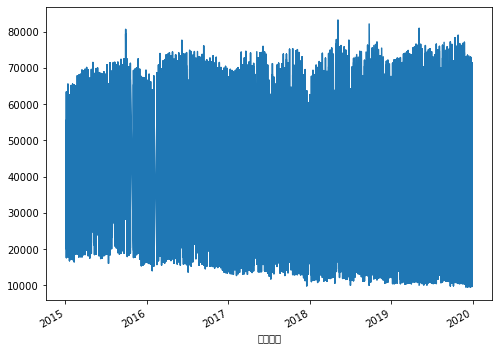

In [19]:
uni_data.plot(subplots=True)

In [20]:
uni_data=uni_data.values

In [21]:
uni_data=(uni_data)/max(uni_data)

In [22]:
len(uni_data)

2072

In [23]:
TRAIN_SPLIT = 1800
tf.random.set_seed(13)

NameError: name 'tf' is not defined

In [153]:
univariate_past_history = 20
univariate_future_target = 0
x_train_uni,y_train_uni = univariate_data(uni_data , 0, TRAIN_SPLIT,univariate_past_history,univariate_future_target)
x_val_uni,y_val_uni = univariate_data(uni_data , TRAIN_SPLIT,None,univariate_past_history,univariate_future_target)

In [154]:
def create_time_steps(length):
    return list(range(-length,0))

In [155]:
def show_plot(plot_data,delta,title):
    labels=['History','True Future','Model Prediction']
    marker = ['.-','rx','go']
    time_steps=create_time_steps(plot_data[0].shape[0])
    if delta:
        future=delta
    else:
        future =0 
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i],marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps,plot_data[i].flatten(),marker[i],label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0],(future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\yhw99\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

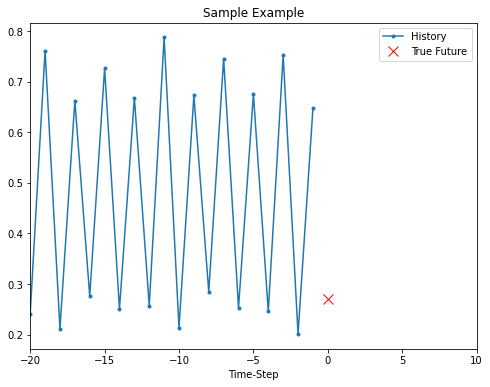

In [156]:
show_plot([x_train_uni[0],y_train_uni[0]],0,'Sample Example')

In [157]:
x_train_uni[0]

array([[0.24182205],
       [0.76137579],
       [0.211707  ],
       [0.66261526],
       [0.27625299],
       [0.72593501],
       [0.25058607],
       [0.66816941],
       [0.2573304 ],
       [0.787199  ],
       [0.21414746],
       [0.67256946],
       [0.28476455],
       [0.74544668],
       [0.2530626 ],
       [0.67532249],
       [0.24637838],
       [0.75215494],
       [0.20145225],
       [0.64709489]])

In [158]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\yhw99\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

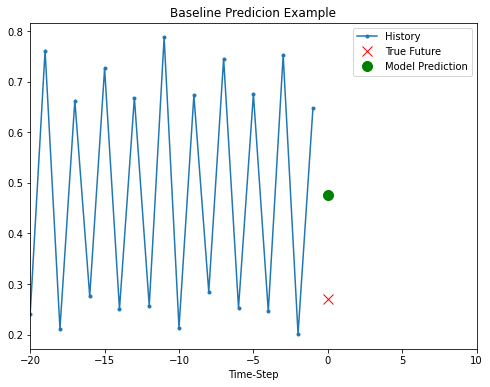

In [159]:
show_plot([x_train_uni[0],y_train_uni[0],baseline(x_train_uni[0])],0,'Baseline Predicion Example')

In [170]:
BATCH_SIZE = 2000
BUFFER_SIZE = 10000

train_univariate=tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate=train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()


In [171]:
simple_lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8,input_shape=x_train_uni.shape[-2:]),tf.keras.layers.Dense(1)])
simple_lstm_model.compile(optimizer='adam' , loss='mae')

In [172]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(252, 1)


In [173]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
simple_lstm_model.fit(train_univariate,epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_univariate,validation_steps=50)

Epoch 1/10
  1/200 [..............................] - 1s 1s/step - loss: 0.3318 - val_loss: 0.3748


In [147]:
from sklearn.preprocessing import MinMaxScaler #정규화 과정

seoul_traffic_data_past.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['1종교통량','2종교통량','3종교통량','총교통량']
df_scaled = scaler.fit_transform(seoul_traffic_data_past[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,1종교통량,2종교통량,3종교통량,총교통량
0,0.143962,0.438934,0.250769,0.186066
1,0.730576,0.710477,0.049006,0.666176
2,0.109960,0.478301,0.239286,0.181295
3,0.619068,0.722877,0.049621,0.566015
4,0.182837,0.317731,0.198585,0.188232
...,...,...,...,...
2067,0.758741,0.735586,0.166906,0.747947
2068,0.038685,0.082455,0.071868,0.016688
2069,0.833790,0.705518,0.820074,0.860523
2070,0.023062,0.094544,0.060180,0.014985


In [122]:
TEST_SIZE = 200
WINDOW_SIZE = 20

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [123]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [124]:
from sklearn.model_selection import train_test_split

feature_cols = ['1종교통량','2종교통량','3종교통량']
label_cols = ['총교통량']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((1481, 20, 3), (371, 20, 3))

In [125]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((200, 3), (200, 1))

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [127]:
traffic_data_2015_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2015_01분기.csv',encoding='cp949')
traffic_data_2015_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2015_02분기.csv',encoding='cp949')
traffic_data_2015_03=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2015_03분기.csv',encoding='cp949')
traffic_data_2015_04=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2015_04분기.csv',encoding='cp949')
traffic_data_2016_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2016_01분기.csv',encoding='cp949')
traffic_data_2016_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2016_02분기.csv',encoding='cp949')
traffic_data_2016_03=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2016_03분기.csv',encoding='cp949')
traffic_data_2016_04=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2016_04분기.csv',encoding='cp949')
traffic_data_2017_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2017_01분기.csv',encoding='cp949')
traffic_data_2017_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2017_02분기.csv',encoding='cp949')
traffic_data_2017_03=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2017_03분기.csv',encoding='cp949')
traffic_data_2017_04=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2017_04분기.csv',encoding='cp949')
traffic_data_2018_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2018_01분기.csv',encoding='cp949')
traffic_data_2018_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2018_02분기.csv',encoding='cp949')
traffic_data_2018_03=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2018_03분기.csv',encoding='cp949')
traffic_data_2018_04=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2018_04분기.csv',encoding='cp949')
traffic_data_2019_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2019_01분기.csv',encoding='cp949')
traffic_data_2019_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2019_02분기.csv',encoding='cp949')
traffic_data_2019_03=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2019_03분기.csv',encoding='cp949')
traffic_data_2019_04=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2019_04분기.csv',encoding='cp949')
traffic_data_2020_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2020_01분기.csv',encoding='cp949')
traffic_data_2020_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2020_02분기.csv',encoding='cp949')
traffic_data_2020_03=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2020_03분기.csv',encoding='cp949')
traffic_data_2020_04=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2020_04분기.csv',encoding='cp949')
traffic_data_2021_01=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2021_01분기.csv',encoding='cp949')
traffic_data_2021_02=pd.read_csv('/content/drive/Shareddrives/삼현텍📈/data/traffic_data/2021_02분기.csv',encoding='cp949')

Epoch 1/25
93/93 [==============================] - 1s 13ms/step - loss: 0.1785 - accuracy: 0.0000e+00 - val_loss: 0.1409 - val_accuracy: 0.0000e+00
Epoch 2/25
93/93 [==============================] - 1s 9ms/step - loss: 0.0762 - accuracy: 6.7522e-04 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 3/25
93/93 [==============================] - 1s 9ms/step - loss: 0.0118 - accuracy: 6.7522e-04 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 4/25
93/93 [==============================] - 1s 9ms/step - loss: 0.0107 - accuracy: 6.7522e-04 - val_loss: 0.0067 - val_accuracy: 0.0000e+00
Epoch 5/25
93/93 [==============================] - 1s 9ms/step - loss: 0.0074 - accuracy: 6.7522e-04 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 6/25
93/93 [==============================] - 1s 10ms/step - loss: 0.0072 - accuracy: 6.7522e-04 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 7/25
93/93 [==============================] - 1s 10ms/step - loss: 0.0056 - accuracy: 6.7522e-04 - val_l